In [2]:
import pandas as pd
import numpy as np
from demoparser2 import DemoParser
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt
import psutil

### Création d'un dictionnaire avec tous les df par matchs

#### Chargement des données agrégées

In [3]:
def log_memory_usage(step=""):
    process = psutil.Process(os.getpid())
    memory_used = process.memory_info().rss / (1024 ** 2)  # Convertit en Mo
    print(f"[{step}] Memory usage: {memory_used:.2f} MB")

In [ ]:
# Créer une liste pour stocker les DataFrames concaténés pour chaque fichier
all_matches = []

# Répertoire contenant les fichiers de démonstration
demo_directory = "D:/Python/projet_cs_v2/demos"

team = 'GENESIUM'

# Parcours des fichiers dans le répertoire
for filename in os.listdir(demo_directory):
    if filename.endswith(".dem"):
        print(f"Processing file: {filename}")
        log_memory_usage("Start of file processing")
        # Chargement de la démo
        demo = DemoParser(os.path.join(demo_directory, filename))

        # Extraction des ticks
        max_tick = demo.parse_event("round_end")
        # first_round_tick = demo.parse_event('round_start').drop([0, 1, 2]).loc[3, 'tick']
        # freezetime_end_tick = demo.parse_event("round_freeze_end")["tick"].drop([0, 1]).tolist()
        log_memory_usage("After extracting ticks")

Processing file: 1-2a7ae284-0830-4b5c-941a-840c8df78164-1-1.dem
[Start of file processing] Memory usage: 148.44 MB
[After extracting ticks] Memory usage: 148.45 MB


In [ ]:
demo.parse_event("round_end")

: 

In [5]:
# Créer une liste pour stocker les DataFrames concaténés pour chaque fichier
all_matches = []

# Répertoire contenant les fichiers de démonstration
demo_directory = "D:/Python/projet_cs_v2/demos_G1"

team = 'zobrux'

# Parcours des fichiers dans le répertoire
for filename in os.listdir(demo_directory):
    if filename.endswith(".dem"):
        print(f"Processing file: {filename}")
        log_memory_usage("Start of file processing")
        # Chargement de la démo
        demo = DemoParser(os.path.join(demo_directory, filename))

        # Extraction du tick max de la partie
        max_tick = demo.parse_event("round_end")["tick"].max()

        # Extraction du premier tick de la partie
        first_round_tick = demo.parse_event('round_start').drop([0,1,2]).loc[3, 'tick'] # on drop le knife round, le warmup round et le RR

        # Extraction de la carte 
        map = pd.DataFrame([demo.parse_header()])

        #tick fin période d'achat
        freezetime_end_tick = demo.parse_event("round_freeze_end")["tick"].drop([0,1]).tolist()# on drop le knife round et le warmup, pas de freezetime au RR

        log_memory_usage("After extracting ticks")

        # Extraction des noms des joueurs et des équipes 
        team_V3 = demo.parse_ticks(["team_clan_name","team_name"])
        team_V3.drop(team_V3[team_V3['tick'] < first_round_tick].index, inplace=True)
        team_V3.drop(team_V3[team_V3['tick'] > max_tick].index, inplace=True)
        team_V3.rename(columns={'team_name':'side'}, inplace=True)
        name_to_team = dict(zip(team_V3['name'], team_V3['team_clan_name']))

        #eco 
        eco = demo.parse_ticks(["current_equip_value", "total_rounds_played"], ticks=freezetime_end_tick)
        if eco['total_rounds_played'].min() == 0:
            eco['total_rounds_played'] = eco['total_rounds_played'] + 1
        eco['current_equip_value'] = eco['current_equip_value'] - 200
        #eco par équipe
        eco_by_players = pd.merge(eco,team_V3, on=['tick','name','steamid'])
        eco_by_team = eco_by_players.groupby(['total_rounds_played','team_clan_name','tick','side'])['current_equip_value'].sum().reset_index()

        # Kills DataFrame
        player_death = demo.parse_event("player_death", other=["game_time", "round_start_time",'total_rounds_played'])
        player_death['total_rounds_played'] = player_death['total_rounds_played'] + 1
        player_death.drop(player_death[player_death['tick'] < first_round_tick].index, inplace=True)
        player_death["player_died_time"] = player_death["game_time"] - player_death["round_start_time"]
        player_death = pd.merge(player_death, team_V3[['team_clan_name','side','name','tick']], left_on=["attacker_name",'tick'], right_on=['name','tick'])
        player_death = player_death.rename(columns={'team_clan_name':'team_clan_name_attacker', 'side':'side_attacker'})
        player_death = pd.merge(player_death, team_V3[['team_clan_name','side','name','tick']], left_on=["user_name",'tick'], right_on=['name','tick'])
        player_death = player_death.rename(columns={'team_clan_name':'team_clan_name_user','side':'side_user'})
        player_death = player_death.drop(columns={'name_y','name_x'})

        # Damage DataFrame
        all_hits_regs = demo.parse_event("player_hurt")#tick=[max_tick]
        all_hits_regs.drop(all_hits_regs[all_hits_regs['tick'] < first_round_tick].index, inplace=True)
        all_hits_regs.drop(all_hits_regs[all_hits_regs['tick'] > max_tick].index, inplace=True)
        all_hits_regs['attacker_team'] = all_hits_regs['attacker_name'].map(name_to_team)
        all_hits_regs['user_team'] = all_hits_regs['user_name'].map(name_to_team)
        all_hits_regs = all_hits_regs[all_hits_regs['attacker_team'] != all_hits_regs['user_team']]

        # Stats DataFrame
        overall_stats = ["total_rounds_played","kills_total","assists_total","deaths_total", "mvps", "headshot_kills_total", 
                         "3k_rounds_total", "4k_rounds_total", "ace_rounds_total" ,"damage_total","utility_damage_total", 
                         "enemies_flashed_total","alive_time_total"]
        agg_stats = demo.parse_ticks(overall_stats, ticks=[max_tick])

        # round_winner
        round_ends = demo.parse_event("round_end", other=["total_rounds_played","team_clan_name"])
        
        def transform_round_end(round_ends, first_round_tick):
            # Vérifier si la première colonne est 'legacy'
            if round_ends.columns[1].lower() == 'legacy':
                round_ends['winner'] = round_ends['winner'].apply(lambda x: 'T' if x == 2 else 'CT' if x == 3 else 'unknown')
                def reason_mapping(x):
                    if x == 9:
                        return 'ct_killed'
                    elif x == 7:
                        return 'bomb_defused'
                    elif x == 8:
                        return 't_killed'
                    elif x == 12:
                        return 't_saved'
                    else:
                        return 'unknown'

                round_ends['reason'] = round_ends['reason'].apply(reason_mapping)
                round_ends.drop(round_ends[round_ends['tick'] <= first_round_tick].index, inplace=True)
                round_ends = round_ends[['ct_team_clan_name','t_team_clan_name','reason', 'tick', 'total_rounds_played', 'winner']]
                round_ends['total_rounds_played'] = round_ends['total_rounds_played'] + 1
            
            else:
                round_ends.drop(round_ends[round_ends['tick'] <= first_round_tick].index, inplace=True)
                round_ends.drop(columns=['round'], inplace=True)
            
            return round_ends

        round_ends = transform_round_end(round_ends, first_round_tick)


        # Identification de l'équipe adverse
        unique_teams = team_V3['team_clan_name'].unique()
        adversary_team = [t for t in unique_teams if t != team][0]  # Trouver l'équipe adverse

        # Sélection des joueurs spécifiés dans zobrux
        df_team = team_V3.loc[team_V3['team_clan_name'] == team, :]

        # Ajouter une colonne avec l'équipe adverse comme Game_id
        df_team['Game_id'] = "VS_"+adversary_team

        # Stocker chaque DataFrame dans un dictionnaire pour ce fichier, y compris eco_info
        match_data = {
            'team_info': df_team,
            'player_death_info': player_death,
            'damage_info': all_hits_regs,
            'agg_stats': agg_stats,
            'eco_info': eco_by_team,
            'round_info': round_ends,
            'map_info' : map
        }

        # Ajout du dictionnaire à la liste
        all_matches.append(match_data)


Processing file: VS_Eldsjalar_Vertigo.dem
[Start of file processing] Memory usage: 148.82 MB
[After extracting ticks] Memory usage: 176.02 MB


C:\Users\Armel\AppData\Local\Temp\ipykernel_10672\1106379451.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_ends['total_rounds_played'] = round_ends['total_rounds_played'] + 1
C:\Users\Armel\AppData\Local\Temp\ipykernel_10672\1106379451.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team['Game_id'] = "VS_"+adversary_team


Processing file: VS_KREATURES_Anubis.dem
[Start of file processing] Memory usage: 498.14 MB
[After extracting ticks] Memory usage: 538.89 MB


C:\Users\Armel\AppData\Local\Temp\ipykernel_10672\1106379451.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team['Game_id'] = "VS_"+adversary_team


Processing file: VS_MadeInPoland_Mirage.dem
[Start of file processing] Memory usage: 672.97 MB
[After extracting ticks] Memory usage: 674.16 MB


C:\Users\Armel\AppData\Local\Temp\ipykernel_10672\1106379451.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_ends['total_rounds_played'] = round_ends['total_rounds_played'] + 1
C:\Users\Armel\AppData\Local\Temp\ipykernel_10672\1106379451.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team['Game_id'] = "VS_"+adversary_team


#### Analyse des df de chaque matchs :

all_matches[id du match][data souhaitée]

In [3]:
all_matches[1]['team_info']

,side,team_clan_name,tick,steamid,name,Game_id
32310,TERRORIST,zobrux,3237,76561198111191178,-silentGG,VS_KREATURES
32312,TERRORIST,zobrux,3237,76561198066661071,OzzieOzz,VS_KREATURES
32313,TERRORIST,zobrux,3237,76561198259827471,godofbaldz,VS_KREATURES
32315,TERRORIST,zobrux,3237,76561198376612283,BELDIYA00,VS_KREATURES
32317,TERRORIST,zobrux,3237,76561198173360875,Spiritix,VS_KREATURES
...,...,...,...,...,...,...
2359390,TERRORIST,zobrux,236075,76561198111191178,-silentGG,VS_KREATURES
2359392,TERRORIST,zobrux,236075,76561198066661071,OzzieOzz,VS_KREATURES
2359393,TERRORIST,zobrux,236075,76561198259827471,godofbaldz,VS_KREATURES
2359395,TERRORIST,zobrux,236075,76561198376612283,BELDIYA00,VS_KREATURES


#### Analyse multi matchs

In [4]:
joueurs = pd.DataFrame()
joueurs['name']  = team_V3.loc[(team_V3['team_clan_name'] == 'zobrux') & (team_V3['tick'] == first_round_tick), 'name']
joueurs = joueurs.reset_index().drop(columns={'index'})

##### Agg Stats

In [5]:
all_players_stats = pd.DataFrame()


for match_data in all_matches:
    # Récupérer les statistiques du match
    stats = match_data['agg_stats']
    
    # Joindre les stats des joueurs
    Stats_joueurs = joueurs.merge(stats, on='name', how='left')
    
    # Ajouter les stats agrégées des joueurs à la liste générale
    all_players_stats = pd.concat([all_players_stats, Stats_joueurs])

# Faire la somme des stats par joueur
all_players_stats_grouped = all_players_stats.groupby('name').sum().reset_index()
all_players_stats_grouped['ADR'] = round(all_players_stats_grouped['damage_total'] / all_players_stats_grouped["total_rounds_played"],2)
all_players_stats_grouped['HS %'] = round((all_players_stats_grouped['headshot_kills_total'] / all_players_stats_grouped['kills_total'])*100,2)
all_players_stats_grouped['KPR'] = round((all_players_stats_grouped['kills_total'] / all_players_stats_grouped['total_rounds_played']), 2)
all_players_stats_grouped['K/D'] = round((all_players_stats_grouped['kills_total'] / all_players_stats_grouped['deaths_total']),2)
all_players_stats_grouped['+/-'] = round((all_players_stats_grouped['kills_total'] - all_players_stats_grouped['deaths_total']),2)
all_players_stats_grouped = all_players_stats_grouped.rename(columns={"total_rounds_played":"Rounds joués","headshot_kills_total":"HS","kills_total":"Kills","assists_total":"Assists","deaths_total":"Deaths","3k_rounds_total":'3K', "4k_rounds_total":'4K', "ace_rounds_total":'5K',"damage_total":"Damages","utility_damage_total":"Utility Damages","enemies_flashed_total":"Flashed Ennemies"})
all_players_stats_grouped = all_players_stats_grouped.drop(columns={"tick","alive_time_total"})
nouvel_ordre_colonnes = [
                'name', 'steamid', 'Rounds joués', 'Kills', 'Deaths', 'Assists', '+/-',
                'K/D', 'Damages', 'ADR', 'KPR', 'HS', 'HS %', '5K', '4K', '3K', 'mvps'
            ]
all_players_stats_grouped = all_players_stats_grouped[nouvel_ordre_colonnes]

In [6]:
all_players_stats_grouped.sort_values(by='ADR',ascending=False)

,name,steamid,Rounds joués,Kills,Deaths,Assists,+/-,K/D,Damages,ADR,KPR,HS,HS %,5K,4K,3K,mvps
1,BELDIYA00,229683595129836849,84,87,52,19,35,1.67,9280,110.48,1.04,57,65.52,0,3,3,13
3,Spiritix,229683594520082625,84,73,53,21,20,1.38,7628,90.81,0.87,33,45.21,0,1,6,15
4,godofbaldz,229683594779482413,84,56,53,18,3,1.06,6005,71.49,0.67,12,21.43,0,1,3,5
0,-silentGG,229683594333573534,84,54,52,22,2,1.04,5618,66.88,0.64,25,46.30,0,0,4,6
2,OzzieOzz,229683594199983213,84,55,48,15,7,1.15,5616,66.86,0.65,31,56.36,0,2,3,9


##### AGG utils

In [7]:
# Initialiser un DataFrame vide pour stocker les stats d'utilitaire des joueurs
all_utils_stats = pd.DataFrame()

# Parcourir chaque match dans 'all_matches'
for match_data in all_matches:
    # Extraction des DataFrames nécessaires
    all_hits_regs = match_data['damage_info']
    stats_utils = match_data['agg_stats']
    player_death = match_data['player_death_info']
    
    # Calcul des flash assist kills
    flash_assist_kill = player_death[player_death['assistedflash'] == True].groupby('assister_name').size().reset_index(name='Flash_assist')
    flash_assist_kill = flash_assist_kill.rename(columns={'assister_name':'name'})
    
    # Calcul des dégâts HE
    he_dmg = all_hits_regs[all_hits_regs["weapon"] == "hegrenade"]
    he_dmg = he_dmg.groupby('attacker_name').sum('dmg_health').reset_index()
    he_dmg = he_dmg.rename(columns={'attacker_name':'name'})
    
    # Calcul des dégâts molotov/incendiaire
    molotov_dmg = all_hits_regs[(all_hits_regs["weapon"] == "molotov") | (all_hits_regs["weapon"] == "inferno")]
    molotov_dmg = molotov_dmg.groupby('attacker_name').sum('dmg_health').reset_index()
    molotov_dmg = molotov_dmg.rename(columns={'attacker_name':'name'})
    
    # Fusion des dégâts HE et molotov
    Utils_joueurs = joueurs.merge(he_dmg[['name','dmg_health']], on='name', how='left').fillna(0)
    Utils_joueurs = Utils_joueurs.merge(molotov_dmg[['name','dmg_health']], on='name', how='left').fillna(0)
    Utils_joueurs = Utils_joueurs.rename(columns={'dmg_health_x':'He_dmg','dmg_health_y':'Fire_dmg'})
    Utils_joueurs['Total_utility_dmg'] = Utils_joueurs['He_dmg'] + Utils_joueurs['Fire_dmg']
    
    # Ajouter les flashs et autres stats
    Utils_joueurs = Utils_joueurs.merge(stats_utils[['name','enemies_flashed_total']], on='name', how='left')
    Utils_joueurs = Utils_joueurs.merge(flash_assist_kill, on='name', how='left')
    
    # Remplir les valeurs manquantes et convertir en entier
    Utils_joueurs[['Flash_assist','He_dmg','Fire_dmg','Total_utility_dmg']] = Utils_joueurs[['Flash_assist','He_dmg','Fire_dmg','Total_utility_dmg']].fillna(0).astype(int)
    
    # Concaténer les stats pour ce match avec les autres
    all_utils_stats = pd.concat([all_utils_stats, Utils_joueurs])

# Agréger les résultats pour tous les matchs
all_utils_stats_grouped = all_utils_stats.groupby('name').sum()

# Afficher les résultats finaux
all_utils_stats_grouped.reset_index()


,name,He_dmg,Fire_dmg,Total_utility_dmg,enemies_flashed_total,Flash_assist
0,-silentGG,186,264,450,16,1
1,BELDIYA00,495,189,684,34,0
2,OzzieOzz,286,52,338,21,2
3,Spiritix,253,120,373,23,0
4,godofbaldz,340,89,429,59,4


##### AGG entries

In [8]:
match_data['player_death_info']

,assistedflash,assister_name,assister_steamid,attacker_name,attacker_steamid,attackerblind,distance,dmg_armor,dmg_health,dominated,...,weapon,weapon_fauxitemid,weapon_itemid,weapon_originalowner_xuid,wipe,player_died_time,team_clan_name_attacker,side_attacker,team_clan_name_user,side_user
0,True,-sagan-,76561198358769095,KRAWCZYKLUKI,76561198312712932,False,8.261380,0,108,0,...,glock,,30194944144,,0,21.046875,Made In Poland,TERRORIST,zobrux,CT
1,False,None,None,BELDIYA00,76561198376612283,False,16.075836,0,124,0,...,usp_silencer,,0,,0,24.796875,zobrux,CT,Made In Poland,TERRORIST
2,False,None,None,-silentGG,76561198111191178,False,33.716152,0,109,0,...,usp_silencer,,26326506826,,0,28.156250,zobrux,CT,Made In Poland,TERRORIST
3,False,None,None,Skrzypekk,76561198852137431,False,32.990910,0,78,0,...,glock,,35079905430,,0,30.734375,Made In Poland,TERRORIST,zobrux,CT
4,False,None,None,bartusss7,76561198877688582,False,14.969774,0,99,0,...,glock,,0,,0,63.500000,Made In Poland,TERRORIST,zobrux,CT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,False,None,None,Spiritix,76561198173360875,False,15.604671,15,108,0,...,ak47,,34805642027,,0,35.750000,zobrux,TERRORIST,Made In Poland,CT
129,False,KRAWCZYKLUKI,76561198312712932,Skrzypekk,76561198852137431,False,22.049940,1,110,0,...,awp,,19816936321,,0,36.468750,Made In Poland,CT,zobrux,TERRORIST
130,False,None,None,Spiritix,76561198173360875,False,14.207709,15,109,0,...,ak47,,34805642027,,0,49.687500,zobrux,TERRORIST,Made In Poland,CT
131,False,Spiritix,76561198173360875,BELDIYA00,76561198376612283,False,24.188189,3,26,0,...,ak47,,35297643185,,0,60.375000,zobrux,TERRORIST,Made In Poland,CT


In [9]:
# Initialiser un DataFrame vide pour stocker les stats d'entry et open
all_opening_stats = pd.DataFrame()

# Parcourir chaque match dans 'all_matches'
for match_data in all_matches:
    player_death = match_data['player_death_info']
    team_V3 = match_data['team_info']
    
    
    # Identifier le premier kill de chaque round
    first_duel = player_death.groupby('total_rounds_played').first().reset_index()

    # Initialiser un DataFrame pour stocker les résultats par joueur pour ce match
    opening_stats = pd.DataFrame({
        'name': player_death['attacker_name'].unique(),
        'entry_attempts(T)': 0,
        'entry_successes(T)': 0,
        'open_attempts(CT)': 0,
        'open_successes(CT)': 0
    })

    # Parcourir chaque premier kill pour déterminer si c'est une tentative d'entry (T) ou d'open (CT)
    for _, row in first_duel.iterrows():
        attacker = row['attacker_name']
        user = row['user_name']
        side_user = row['side_user']

        # Si le joueur tué est un CT, c'est une tentative d'entry pour un Terrorist
        if side_user == 'CT':
            opening_stats.loc[opening_stats['name'] == attacker, 'entry_attempts(T)'] += 1
            opening_stats.loc[opening_stats['name'] == attacker, 'entry_successes(T)'] += 1
            opening_stats.loc[opening_stats['name'] == user, 'open_attempts(CT)'] += 1

        # Si le joueur tué est un Terroriste, c'est une tentative d'open pour un CT
        elif side_user == 'TERRORIST':
            opening_stats.loc[opening_stats['name'] == attacker, 'open_attempts(CT)'] += 1
            opening_stats.loc[opening_stats['name'] == attacker, 'open_successes(CT)'] += 1
            opening_stats.loc[opening_stats['name'] == user, 'entry_attempts(T)'] += 1

    # Concaténer les résultats pour ce match avec les autres
    all_opening_stats = pd.concat([all_opening_stats, opening_stats])

# Agréger les résultats pour tous les matchs
all_opening_stats_grouped = all_opening_stats.groupby('name').sum().reset_index()

# Calcul des pourcentages de réussite
all_opening_stats_grouped["%_entry_success(T)"] = round((all_opening_stats_grouped["entry_successes(T)"] / all_opening_stats_grouped["entry_attempts(T)"])*100, 0)
all_opening_stats_grouped["%_open_success(CT)"] = round((all_opening_stats_grouped["open_successes(CT)"] / all_opening_stats_grouped["open_attempts(CT)"])*100, 0)

# Réorganiser les colonnes
column_order = ['name', 'entry_attempts(T)', 'entry_successes(T)', '%_entry_success(T)', 'open_attempts(CT)', 'open_successes(CT)', '%_open_success(CT)']
all_opening_stats_grouped = all_opening_stats_grouped[column_order]

# Fusionner avec le DataFrame 'joueurs'
entry_stats = joueurs.merge(all_opening_stats_grouped, on='name', how='left')

# Afficher les résultats finaux
entry_stats


,name,entry_attempts(T),entry_successes(T),%_entry_success(T),open_attempts(CT),open_successes(CT),%_open_success(CT)
0,Spiritix,8,6,75.0,17,12,71.0
1,OzzieOzz,5,2,40.0,6,1,17.0
2,-silentGG,6,3,50.0,7,5,71.0
3,godofbaldz,11,8,73.0,10,5,50.0
4,BELDIYA00,9,7,78.0,5,4,80.0


##### AGG Trade

In [10]:
player_death

,assistedflash,assister_name,assister_steamid,attacker_name,attacker_steamid,attackerblind,distance,dmg_armor,dmg_health,dominated,...,weapon,weapon_fauxitemid,weapon_itemid,weapon_originalowner_xuid,wipe,player_died_time,team_clan_name_attacker,side_attacker,team_clan_name_user,side_user
0,True,-sagan-,76561198358769095,KRAWCZYKLUKI,76561198312712932,False,8.261380,0,108,0,...,glock,,30194944144,,0,21.046875,Made In Poland,TERRORIST,zobrux,CT
1,False,None,None,BELDIYA00,76561198376612283,False,16.075836,0,124,0,...,usp_silencer,,0,,0,24.796875,zobrux,CT,Made In Poland,TERRORIST
2,False,None,None,-silentGG,76561198111191178,False,33.716152,0,109,0,...,usp_silencer,,26326506826,,0,28.156250,zobrux,CT,Made In Poland,TERRORIST
3,False,None,None,Skrzypekk,76561198852137431,False,32.990910,0,78,0,...,glock,,35079905430,,0,30.734375,Made In Poland,TERRORIST,zobrux,CT
4,False,None,None,bartusss7,76561198877688582,False,14.969774,0,99,0,...,glock,,0,,0,63.500000,Made In Poland,TERRORIST,zobrux,CT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,False,None,None,Spiritix,76561198173360875,False,15.604671,15,108,0,...,ak47,,34805642027,,0,35.750000,zobrux,TERRORIST,Made In Poland,CT
129,False,KRAWCZYKLUKI,76561198312712932,Skrzypekk,76561198852137431,False,22.049940,1,110,0,...,awp,,19816936321,,0,36.468750,Made In Poland,CT,zobrux,TERRORIST
130,False,None,None,Spiritix,76561198173360875,False,14.207709,15,109,0,...,ak47,,34805642027,,0,49.687500,zobrux,TERRORIST,Made In Poland,CT
131,False,Spiritix,76561198173360875,BELDIYA00,76561198376612283,False,24.188189,3,26,0,...,ak47,,35297643185,,0,60.375000,zobrux,TERRORIST,Made In Poland,CT


In [11]:
# Initialiser des listes globales pour stocker les Traded Deaths et Trade Kills pour toutes les parties
traded_deaths_global = []
trade_kills_global = []

# Boucle sur chaque match dans 'all_matches'
for match_data in all_matches:
    player_death = match_data['player_death_info']  # Supposons que les infos de chaque match soient dans 'player_death_info'
    
    # Boucle sur chaque round
    for round_number in player_death['total_rounds_played'].unique():
        round_data = player_death[player_death['total_rounds_played'] == round_number]
        
        # Trier les événements par ordre chronologique (temps de mort)
        round_data = round_data.sort_values(by='player_died_time')
        
        # Calculer les traded deaths
        for player in player_death['user_name'].unique():
            player_deaths = round_data[round_data['user_name'] == player]
            
            # Pour chaque mort du joueur, chercher si son tueur est tué dans les 2 secondes après
            for _, death_row in player_deaths.iterrows():
                death_time = death_row['player_died_time']
                attacker = death_row['attacker_name']
                attacker_side = death_row['side_attacker']
                victim_side = death_row['side_user']
                
                # Chercher l'apparition du tueur (attacker) dans 'user_name' dans les lignes suivantes
                subsequent_rows = round_data[round_data.index > death_row.name]
                
                for _, next_row in subsequent_rows.iterrows():
                    if next_row['user_name'] == attacker and next_row['player_died_time'] <= death_time + 2:
                        # Si l'attaquant est tué dans les 2 secondes après avoir tué 'player'
                        
                        # Stocker le traded death pour la victime
                        traded_deaths_global.append({
                            'player': player, 
                            'side_user': victim_side, 
                            'side_attacker': attacker_side, 
                            'round': round_number
                        })
                        
                        # Stocker le trade kill pour le joueur qui a tué l'attaquant
                        trade_killer = next_row['attacker_name']
                        trade_kills_global.append({
                            'player': trade_killer, 
                            'side_user': next_row['side_user'], 
                            'side_attacker': next_row['side_attacker'], 
                            'round': round_number
                        })
                        break  # Stopper la recherche après avoir trouvé un trade

# Convertir les traded deaths et trade kills globaux en DataFrames
traded_deaths_df_global = pd.DataFrame(traded_deaths_global)
trade_kills_df_global = pd.DataFrame(trade_kills_global)

# Calculer les volumes de traded deaths et trade kills par joueur et par side
traded_deaths_count_global = traded_deaths_df_global.groupby(['player', 'side_user']).size().unstack(fill_value=0).reset_index()
trade_kills_count_global = trade_kills_df_global.groupby(['player', 'side_user']).size().unstack(fill_value=0).reset_index()

# Renommer les colonnes pour les traded deaths et trade kills
traded_deaths_count_global.columns = ['player', 'Traded_deaths(CT)', 'Traded_deaths(T)']
trade_kills_count_global.columns = ['player', 'Trade_kills(CT)', 'Trade_kills(T)']

# Fusionner les deux DataFrames (traded deaths et trade kills) pour avoir toutes les infos sur chaque joueur
trade_df_global = pd.merge(traded_deaths_count_global, trade_kills_count_global, on='player', how='outer')

# Remplacer les NaN par 0 (pour les cas où un joueur n'a pas de traded death ou de trade kill)
trade_df_global.fillna(0, inplace=True)

# Convertir les colonnes en int
trade_df_global = trade_df_global.rename(columns={'player': 'name'})
trade_df_global['Traded_deaths(CT)'] = trade_df_global['Traded_deaths(CT)'].astype(int)
trade_df_global['Traded_deaths(T)'] = trade_df_global['Traded_deaths(T)'].astype(int)
trade_df_global['Trade_kills(CT)'] = trade_df_global['Trade_kills(CT)'].astype(int)
trade_df_global['Trade_kills(T)'] = trade_df_global['Trade_kills(T)'].astype(int)

trade_stats = pd.merge(joueurs,trade_df_global,on='name',how='left')
trade_stats.head()


,name,Traded_deaths(CT),Traded_deaths(T),Trade_kills(CT),Trade_kills(T)
0,Spiritix,0,1,7,2
1,OzzieOzz,2,4,3,3
2,-silentGG,1,5,4,0
3,godofbaldz,3,4,2,1
4,BELDIYA00,3,5,3,3


In [12]:
trade_kills_df_global

,player,side_user,side_attacker,round
0,OzzieOzz,TERRORIST,CT,2
1,QUAKQUAK5,CT,TERRORIST,3
2,QUAKQUAK5,CT,TERRORIST,3
3,BELDIYA00,TERRORIST,CT,4
4,OzzieOzz,TERRORIST,CT,6
...,...,...,...,...
71,Spiritix,CT,TERRORIST,15
72,Skrzypekk,TERRORIST,CT,17
73,Skrzypekk,TERRORIST,CT,17
74,Spiritix,CT,TERRORIST,17


##### AGG advanced stats

In [13]:
# Initialiser un dictionnaire global pour stocker les résultats cumulés des joueurs
player_stats_global = {}

# Parcourir chaque match dans 'all_matches'
for match_data in all_matches:
    player_death = match_data['player_death_info']
    
    # Initialiser un dictionnaire pour stocker les résultats des joueurs pour ce match
    player_stats = {}

    # Boucle sur chaque round dans le match
    for round_number in player_death['total_rounds_played'].unique():
        round_data = player_death[player_death['total_rounds_played'] == round_number]
        
        # Trier les événements par ordre chronologique (temps de mort)
        round_data = round_data.sort_values(by='player_died_time')
        
        # Liste des joueurs ayant survécu
        survived_players = set(player_death['user_name'].unique()) - set(round_data['user_name'].unique())
        
        # Boucler sur chaque joueur impliqué dans le round
        for player in player_death['user_name'].unique():
            if player not in player_stats:
                player_stats[player] = {'Kills': 0, 'Assists': 0,'Deaths': 0, 'KAST_rounds': 0, 'total_rounds': 0, 'Traded_deaths': 0}
            
            player_stats[player]['total_rounds'] += 1  # Incrémenter les rounds totaux
            kast_contributed = False  # Flag pour vérifier la contribution au KAST dans ce round
            
            # Vérifier et comptabiliser tous les kills pour ce round
            kills = round_data[round_data['attacker_name'] == player]
            if len(kills) > 0:
                player_stats[player]['Kills'] += len(kills)
                player_stats[player]['KAST_rounds'] += 1  # Kill fait partie du KAST
                kast_contributed = True  # Marquer que le joueur a contribué au KAST

            # Vérifier et comptabiliser tous les deaths pour ce round
            deaths = round_data[round_data['user_name'] == player]
            if len(deaths) > 0:
                player_stats[player]['Deaths'] += len(deaths)

            # Vérifier et comptabiliser tous les assists pour ce round
            if not kast_contributed:  # Si le joueur n'a pas encore contribué
                assists = round_data[round_data['assister_name'] == player]
                if len(assists) > 0:
                    player_stats[player]['Assists'] += len(assists)
                    player_stats[player]['KAST_rounds'] += 1  # Assist fait partie du KAST
                    kast_contributed = True  # Marquer que le joueur a contribué au KAST

            # Vérifier la survie du joueur
            if not kast_contributed:  # Si le joueur n'a pas encore contribué
                if player in survived_players:
                    player_stats[player]['KAST_rounds'] += 1  # Survie fait partie du KAST
                    kast_contributed = True  # Marquer que le joueur a contribué au KAST

            # Calculer les traded deaths
            player_deaths = round_data[round_data['user_name'] == player]
            # Pour chaque mort du joueur, on va chercher si son tueur est tué dans les 2 secondes après
            for _, death_row in player_deaths.iterrows():
                death_time = death_row['player_died_time']
                attacker = death_row['attacker_name']
                attacker_side = death_row['side_attacker']
                
                # Chercher l'apparition du tueur (attacker) dans 'user_name' dans les lignes suivantes
                subsequent_rows = round_data[round_data.index > death_row.name]  # Scanner les lignes suivantes dans le round
                
                for _, next_row in subsequent_rows.iterrows():
                    if next_row['user_name'] == attacker and next_row['player_died_time'] <= death_time + 2:
                        # Si l'attaquant est tué dans les 2 secondes après avoir tué 'player'
                        player_stats[player]['Traded_deaths'] += 1  # Incrémenter les traded deaths pour le joueur tué (victim)
                        
                        # Ajouter cette traded death dans le calcul du KAST pour la victime (si pas déjà contribué)
                        if not kast_contributed:
                            player_stats[player]['KAST_rounds'] += 1  # Un traded death compte pour le KAST
                            kast_contributed = True  # Marquer que le joueur a contribué au KAST
                        break  # Stopper la recherche après avoir trouvé un trade

    # Cumul des résultats du match dans le dictionnaire global
    for player, stats in player_stats.items():
        if player not in player_stats_global:
            player_stats_global[player] = stats
        else:
            # Cumul des statistiques du match dans les résultats globaux
            player_stats_global[player]['Kills'] += stats['Kills']
            player_stats_global[player]['Assists'] += stats['Assists']
            player_stats_global[player]['Deaths'] += stats['Deaths']
            player_stats_global[player]['KAST_rounds'] += stats['KAST_rounds']
            player_stats_global[player]['total_rounds'] += stats['total_rounds']
            player_stats_global[player]['Traded_deaths'] += stats['Traded_deaths']

# Calculer le KAST% et l'Impact Rating pour chaque joueur
for player, stats_rating in player_stats_global.items():
    stats_rating['KAST%'] = round((stats_rating['KAST_rounds'] / stats_rating['total_rounds']) * 100, 1)
    kills_per_round = stats_rating['Kills'] / stats_rating['total_rounds']
    assists_per_round = stats_rating['Assists'] / stats_rating['total_rounds']
    deaths_per_round = stats_rating['Deaths'] / stats_rating['total_rounds']
    stats_rating["KPR"] = round(kills_per_round, 2)
    stats_rating["APR"] = round(assists_per_round, 2)
    stats_rating['DPR'] = round(deaths_per_round, 2)
    # Calcul de l'Impact Rating
    stats_rating['Impact'] = round((2.13 * kills_per_round) + (0.42 * assists_per_round) - 0.41,2)

# Convertir le dictionnaire global en DataFrame pour un affichage plus simple
advanced_stats_df = pd.DataFrame(player_stats_global).T.reset_index()

# Renommer la colonne 'index' en 'player' pour plus de clarté
advanced_stats_df.rename(columns={'index': 'name'}, inplace=True)

# Effectuer la fusion avec le DataFrame stats
advanced_stats_df = pd.merge(advanced_stats_df, all_players_stats_grouped[['name', 'ADR']], left_on='name', right_on='name', how='left')


# Calculer le Rating
advanced_stats_df['Rating'] = round((0.0073 * advanced_stats_df['KAST%']) + \
                              (0.3591 * (advanced_stats_df['KPR'])) + \
                              (-0.5329 * (advanced_stats_df['DPR'])) + \
                              (0.2372 * advanced_stats_df['Impact']) + \
                              (0.0032 * advanced_stats_df['ADR']) + 0.1587,2)

# Afficher le DataFrame final
advanced_stats_df = advanced_stats_df.astype({'Kills':int,'Assists':int,'Deaths':int,'KAST_rounds':int,'total_rounds':int,'Traded_deaths':int})


In [14]:
advanced_stats_df= pd.merge(joueurs,advanced_stats_df,on='name',how='left')
advanced_stats_df

,name,Kills,Assists,Deaths,KAST_rounds,total_rounds,Traded_deaths,KAST%,KPR,APR,DPR,Impact,ADR,Rating
0,Spiritix,73,10,53,65,84,1,77.4,0.87,0.12,0.63,1.49,90.81,1.34
1,OzzieOzz,55,12,48,61,84,6,72.6,0.65,0.14,0.57,1.04,66.86,1.08
2,-silentGG,54,10,52,65,84,6,77.4,0.64,0.12,0.62,1.01,66.88,1.08
3,godofbaldz,56,13,53,67,84,7,79.8,0.67,0.15,0.63,1.07,71.49,1.13
4,BELDIYA00,87,7,51,69,84,8,82.1,1.04,0.08,0.61,1.83,110.48,1.59


In [15]:
Final_scoreboard= all_players_stats_grouped.merge(advanced_stats_df[['name','Traded_deaths','KAST%','Impact','Rating']],on='name',how='left')
Final_scoreboard.drop(columns={'steamid','Traded_deaths'},inplace=True)
Final_scoreboard

,name,Rounds joués,Kills,Deaths,Assists,+/-,K/D,Damages,ADR,KPR,HS,HS %,5K,4K,3K,mvps,KAST%,Impact,Rating
0,-silentGG,84,54,52,22,2,1.04,5618,66.88,0.64,25,46.30,0,0,4,6,77.4,1.01,1.08
1,BELDIYA00,84,87,52,19,35,1.67,9280,110.48,1.04,57,65.52,0,3,3,13,82.1,1.83,1.59
2,OzzieOzz,84,55,48,15,7,1.15,5616,66.86,0.65,31,56.36,0,2,3,9,72.6,1.04,1.08
3,Spiritix,84,73,53,21,20,1.38,7628,90.81,0.87,33,45.21,0,1,6,15,77.4,1.49,1.34
4,godofbaldz,84,56,53,18,3,1.06,6005,71.49,0.67,12,21.43,0,1,3,5,79.8,1.07,1.13


##### AGG ecofrags

In [16]:
# Initialiser un DataFrame global pour stocker les kills par catégorie cumulés
all_team_eco_kills = pd.DataFrame()

# Parcourir chaque match dans 'all_matches'
for match_data in all_matches:
    trade_df = match_data['player_death_info']  # DataFrame des kills
    eco_by_team = match_data['eco_info']  # DataFrame de l'économie de l'équipe
    game_id = match_data['team_info']['Game_id'].iloc[0]  # Utiliser le même Game_id pour cette partie

    # Ajouter la colonne Game_id aux kills et à l'économie pour différencier les parties
    trade_df['Game_id'] = game_id
    eco_by_team['Game_id'] = game_id

    # Fusionner les données de kills avec l'économie totale de l'équipe de l'attaquant
    df_merged_team = pd.merge(trade_df, eco_by_team, how='left', 
                              left_on=['total_rounds_played', 'team_clan_name_user', 'Game_id'], 
                              right_on=['total_rounds_played', 'team_clan_name', 'Game_id'])

    # Appliquer la fonction de catégorisation pour classer les kills
    def categorize_kill(row):
        if row['total_rounds_played'] in [1, 13]:
            return 'Pistol round'
        elif row['current_equip_value'] <= 3500:
            return 'Against full eco'
        elif row['current_equip_value'] <= 18000:
            return 'Against force buy'
        else:
            return 'Against full buy'

    # Appliquer la fonction sur les kills du match
    df_merged_team['kill_category'] = df_merged_team.apply(categorize_kill, axis=1)

    # Utiliser pivot_table pour compter les kills par catégorie et par joueur
    team_eco_kills = df_merged_team.pivot_table(index='attacker_name', columns='kill_category', aggfunc='size', fill_value=0)

    # Ajouter les résultats pour ce match aux résultats cumulés
    all_team_eco_kills = pd.concat([all_team_eco_kills, team_eco_kills])

# Agréger les résultats cumulés pour tous les matchs
all_team_eco_kills_grouped = all_team_eco_kills.groupby('attacker_name').sum()

# Afficher les résultats finaux
all_team_eco_kills_grouped.head()

kill_category,Against force buy,Against full buy,Against full eco,Pistol round
attacker_name,,,,
-Weppling,5,14,0,1
-sagan-,0,4,0,1
-silentGG,5,38,6,5
-waLus-,4,12,0,2
3PARABELLUM,2,9,3,5


In [17]:
eco_stats = pd.merge(joueurs,all_team_eco_kills_grouped,left_on='name',right_on='attacker_name',how='left')
eco_stats

,name,Against force buy,Against full buy,Against full eco,Pistol round
0,Spiritix,20,43,7,3
1,OzzieOzz,10,38,3,4
2,-silentGG,5,38,6,5
3,godofbaldz,5,39,8,4
4,BELDIYA00,11,64,6,6


#### Analyse Saison

- Nombre de victoires
- Nombre de défaites
- plus long winstreak
- Winrate par cartes
- % pistols remportés
- largest win
- closest game
- MVP de l'équipe

In [22]:
all_matches[2]['round_info']

,ct_team_clan_name,t_team_clan_name,reason,tick,total_rounds_played,winner
1,zobrux,Made In Poland,ct_killed,32782,1,T
2,zobrux,Made In Poland,ct_killed,38631,2,T
3,zobrux,Made In Poland,unknown,44600,3,T
4,zobrux,Made In Poland,bomb_defused,50678,4,CT
5,zobrux,Made In Poland,t_killed,58398,5,CT
6,zobrux,Made In Poland,t_killed,64015,6,CT
7,zobrux,Made In Poland,t_killed,69746,7,CT
8,zobrux,Made In Poland,t_killed,74951,8,CT
9,zobrux,Made In Poland,ct_killed,84274,9,T
10,zobrux,Made In Poland,t_killed,90223,10,CT


##### Team record

In [23]:
# Nom de l'équipe dont on veut suivre le record
team_name = "zobrux"

# Compteurs pour victoires et défaites
wins = 0
losses = 0

# Liste pour stocker les scores de chaque match
match_scores = []

# Fonction pour calculer le score d'une partie et déterminer le gagnant
def calculate_match_result(round_info_df, team_name):
    team_wins = 0
    opponent_wins = 0

    # Initialiser la première équipe CT
    current_ct_team = round_info_df['ct_team_clan_name'].iloc[0]
    
    for index, row in round_info_df.iterrows():
        # Si l'équipe CT change, cela signifie un changement de côté
        if row['ct_team_clan_name'] != current_ct_team:
            current_ct_team = row['ct_team_clan_name']
        
        # Calculer les victoires en fonction du gagnant du round (CT ou T)
        if row['winner'] == 'CT':
            if row['ct_team_clan_name'] == team_name:
                team_wins += 1
            else:
                opponent_wins += 1
        elif row['winner'] == 'T':
            if row['t_team_clan_name'] == team_name:
                team_wins += 1
            else:
                opponent_wins += 1

    return team_wins, opponent_wins

# Parcourir toutes les parties stockées dans la liste all_matches
for match in all_matches:  # match est un dictionnaire contenant 'round_info'
    round_info_df = match['round_info']
    
    # Calculer le résultat du match
    team_wins, opponent_wins = calculate_match_result(round_info_df, team_name)

    # Enregistrer le score du match
    match_scores.append((team_wins, opponent_wins))

    # Comparer le score final pour déterminer si l'équipe a gagné ou perdu
    if team_wins > opponent_wins:
        wins += 1
    else:
        losses += 1

# Afficher le nombre de victoires et de défaites de l'équipe
print(f"Record de {team_name} : {wins} victoires - {losses} défaites")

# Afficher les scores de chaque match
for i, score in enumerate(match_scores):
    print(f"Match {i+1} : {team_name} {score[0]} - Opponent {score[1]}")



Record de zobrux : 3 victoires - 0 défaites
Match 1 : zobrux 19 - Opponent 17
Match 2 : zobrux 16 - Opponent 14
Match 3 : zobrux 13 - Opponent 5


In [24]:
# Nom de l'équipe dont on veut suivre le record
team_name = "zobrux"

# Liste pour stocker les informations des matchs
match_data = []

# Fonction pour calculer le score d'une partie et déterminer le gagnant
def calculate_round_result(round_info_df, team_name):
    team_wins = 0
    opponent_wins = 0

    # Initialiser la première équipe CT
    current_ct_team = round_info_df['ct_team_clan_name'].iloc[0]
    
    for index, row in round_info_df.iterrows():
        # Si l'équipe CT change, cela signifie un changement de côté
        if row['ct_team_clan_name'] != current_ct_team:
            current_ct_team = row['ct_team_clan_name']
        
        # Calculer les victoires en fonction du gagnant du round (CT ou T)
        if row['winner'] == 'CT':
            if row['ct_team_clan_name'] == team_name:
                team_wins += 1
            else:
                opponent_wins += 1
        elif row['winner'] == 'T':
            if row['t_team_clan_name'] == team_name:
                team_wins += 1
            else:
                opponent_wins += 1

    return team_wins, opponent_wins

# Parcourir toutes les parties stockées dans la liste all_matches
for i, match in enumerate(all_matches):  # match est un dictionnaire contenant 'round_info', 'map_info' et 'team_info'
    round_info_df = match['round_info']
    
    # Calculer le résultat du match
    team_wins, opponent_wins = calculate_round_result(round_info_df, team_name)

    # Obtenir le nom du match (Game_id) et la map jouée
    game_id = match['team_info']['Game_id'].iloc[0]
    map_name = match['map_info']['map_name'].iloc[0]

    # Déterminer l'équipe victorieuse
    if team_wins > opponent_wins:
        winning_team = team_name
    else:
        winning_team = round_info_df['ct_team_clan_name'].iloc[0] if opponent_wins > team_wins else round_info_df['t_team_clan_name'].iloc[0]

    # Ajouter les informations du match dans la liste
    match_data.append({
        "Match id": i + 1,
        "Game Name": game_id,
        "Map": map_name,
        "Rounds Won by zobrux": team_wins,
        "Rounds Won by Opponent": opponent_wins,
        "Winning Team": winning_team
    })

# Créer un DataFrame à partir des données de match
match_df = pd.DataFrame(match_data)

# Afficher le DataFrame
match_df

,Match id,Game Name,Map,Rounds Won by zobrux,Rounds Won by Opponent,Winning Team
0,1,VS_Eldsjalar,de_vertigo,19,17,zobrux
1,2,VS_KREATURES,de_anubis,16,14,zobrux
2,3,VS_Made In Poland,de_mirage,13,5,zobrux


In [25]:
match_data

[{'Match id': 1,
  'Game Name': 'VS_Eldsjalar',
  'Map': 'de_vertigo',
  'Rounds Won by zobrux': 19,
  'Rounds Won by Opponent': 17,
  'Winning Team': 'zobrux'},
 {'Match id': 2,
  'Game Name': 'VS_KREATURES',
  'Map': 'de_anubis',
  'Rounds Won by zobrux': 16,
  'Rounds Won by Opponent': 14,
  'Winning Team': 'zobrux'},
 {'Match id': 3,
  'Game Name': 'VS_Made In Poland',
  'Map': 'de_mirage',
  'Rounds Won by zobrux': 13,
  'Rounds Won by Opponent': 5,
  'Winning Team': 'zobrux'}]

In [26]:
# Nombre de victoires de zobrux
own_team_wins = match_df[match_df['Winning Team'] == team_name].shape[0]

# Nombre de défaites de zobrux
own_team_losses = match_df[match_df['Winning Team'] != team_name].shape[0]

print(f"Nombre de victoires de {team_name} : {own_team_wins}")
print(f"Nombre de défaites de {team_name} : {own_team_losses}")

Nombre de victoires de zobrux : 3
Nombre de défaites de zobrux : 0


##### Winstreak

In [27]:
# Calcul du plus long winstreak
winstreak = 0
current_streak = 0

for winning_team in match_df['Winning Team']:
    if winning_team == team_name:
        current_streak += 1
        winstreak = max(winstreak, current_streak)
    else:
        current_streak = 0

print(f"Le plus long winstreak de {team_name} : {winstreak}")

Le plus long winstreak de zobrux : 3


##### Map Winrate

In [28]:
match_df

,Match id,Game Name,Map,Rounds Won by zobrux,Rounds Won by Opponent,Winning Team
0,1,VS_Eldsjalar,de_vertigo,19,17,zobrux
1,2,VS_KREATURES,de_anubis,16,14,zobrux
2,3,VS_Made In Poland,de_mirage,13,5,zobrux


In [29]:
# Nombre de fois où chaque carte a été jouée et le taux de victoire
map_stats = match_df.groupby('Map').agg(
    times_played=('Map', 'size'),
    wins_on_map=('Winning Team', lambda x: (x == team_name).sum())
)

# Calcul du pourcentage de victoire par carte
map_stats['winrate'] = (map_stats['wins_on_map'] / map_stats['times_played']) * 100

print(map_stats)

            times_played  wins_on_map  winrate
Map                                           
de_anubis              1            1    100.0
de_mirage              1            1    100.0
de_vertigo             1            1    100.0


##### Largest and closest win and loss

In [30]:
# analyse des victoires et defaites
match_df['round_diff'] = abs(match_df['Rounds Won by zobrux'] - match_df['Rounds Won by Opponent'])

# Filtrer les victoires et les défaites de zobrux
zobrux_victories = match_df[match_df['Winning Team'] == team_name]
zobrux_losses = match_df[match_df['Winning Team'] != team_name]

# Si zobrux a gagné au moins un match, trouver la victoire la plus large et la plus serrée
if not zobrux_victories.empty:
    # Victoire la plus large
    largest_win = zobrux_victories.loc[zobrux_victories['round_diff'].idxmax()]

    # Victoire la plus serrée
    closest_win = zobrux_victories.loc[zobrux_victories['round_diff'].idxmin()]

    print(f"Victoire la plus large : {largest_win['Game Name']} sur {largest_win['Map']} avec {largest_win['Rounds Won by zobrux']} - {largest_win['Rounds Won by Opponent']}")
    print(f"Victoire la plus serrée : {closest_win['Game Name']} sur {closest_win['Map']} avec {closest_win['Rounds Won by zobrux']} - {closest_win['Rounds Won by Opponent']}")
else:
    print(f"{team_name} n'a pas encore gagné de match.")

# Si zobrux a perdu au moins un match, trouver la défaite la plus large et la plus serrée
if not zobrux_losses.empty:
    # Défaite la plus large
    largest_loss = zobrux_losses.loc[zobrux_losses['round_diff'].idxmax()]

    # Défaite la plus serrée
    closest_loss = zobrux_losses.loc[zobrux_losses['round_diff'].idxmin()]

    print(f"Défaite la plus large : {largest_loss['Game Name']} sur {largest_loss['Map']} avec {largest_loss['Rounds Won by zobrux']} - {largest_loss['Rounds Won by Opponent']}")
    print(f"Défaite la plus serrée : {closest_loss['Game Name']} sur {closest_loss['Map']} avec {closest_loss['Rounds Won by zobrux']} - {closest_loss['Rounds Won by Opponent']}")
else:
    print(f"{team_name} n'a pas encore perdu de match.")

Victoire la plus large : VS_Made In Poland sur de_mirage avec 13 - 5
Victoire la plus serrée : VS_Eldsjalar sur de_vertigo avec 19 - 17
zobrux n'a pas encore perdu de match.


##### Round Analysis

In [31]:
# Initialiser un DataFrame global pour stocker les rounds par catégorie cumulés
all_matches_round_analysis = pd.DataFrame()

# Initialiser des compteurs globaux pour les cas particuliers
total_force_against_zobrux_lost = 0
total_eco_against_zobrux_lost = 0
total_zobrux_eco_against_full_win = 0
total_zobrux_force_against_full_win = 0

# Parcourir chaque match dans 'all_matches'
for match_data in all_matches:
    eco_by_team = match_data['eco_info']  # DataFrame de l'économie de l'équipe
    game_id = match_data['team_info']['Game_id'].iloc[0]  # Utiliser le même Game_id pour cette partie
    round_info = match_data['round_info']
    
    # Ajouter la colonne Game_id aux rounds et à l'économie pour différencier les parties
    eco_by_team['Game_id'] = game_id
    round_info['Game_id'] = game_id

    # Fusionner les données de rounds avec l'économie totale de l'équipe de l'attaquant
    df_merged_team = pd.merge(eco_by_team, round_info[['total_rounds_played', 'Game_id','winner']], how='left', 
                              left_on=['total_rounds_played','Game_id'], 
                              right_on=['total_rounds_played', 'Game_id'])
    df_merged_team['side'] = df_merged_team['side'].replace({'TERRORIST': 'T'})

    # Appliquer la fonction de catégorisation pour classer les rounds
    def categorize_rounds(row):
        if row['total_rounds_played'] in [1, 13]:
            return 'Pistol round'
        elif row['current_equip_value'] <= 3500:
            return 'Eco round'
        elif row['current_equip_value'] <= 18000:
            return 'Force buy round'
        else:
            return 'Full buy round'

    # Appliquer la fonction sur les rounds du match
    df_merged_team['round_category'] = df_merged_team.apply(categorize_rounds, axis=1)
    df_merged_team['is_team'] = df_merged_team['team_clan_name'] == team
    df_merged_team = df_merged_team.sort_values(by=['total_rounds_played', 'is_team'], ascending=[True, False])
    df_merged_team = df_merged_team.drop(columns=['is_team'])
    
    # Filtrer les rounds joués par zobrux
    rounds_team = df_merged_team[df_merged_team['team_clan_name'] == team]

    # Calculer le nombre total de rounds joués dans chaque catégorie d'achat
    total_rounds_per_category = rounds_team['round_category'].value_counts()

    # Calculer le nombre de victoires par catégorie d'achat
    wins_per_category = rounds_team[rounds_team['winner'] == rounds_team['side']]['round_category'].value_counts()

    # Calculer le nombre de défaites par catégorie d'achat
    losses_per_category = rounds_team[rounds_team['winner'] != rounds_team['side']]['round_category'].value_counts()

    # Remplir les NaN avec 0
    wins_per_category = wins_per_category.fillna(0).astype(int)
    losses_per_category = losses_per_category.fillna(0).astype(int)

    # Ajouter les statistiques du match actuel dans le DataFrame global
    match_stats = pd.DataFrame({
        'total_rounds': total_rounds_per_category,
        'wins': wins_per_category,
        'losses': losses_per_category
    })

    # Cumuler les résultats dans le DataFrame global
    all_matches_round_analysis = pd.concat([all_matches_round_analysis, match_stats])

    # Grouper par catégorie pour obtenir les statistiques cumulées
    cumulative_stats = all_matches_round_analysis.groupby('round_category').sum()

    # Calculer les pourcentages de victoires et de défaites
    cumulative_stats['win_%'] = round((cumulative_stats['wins'] / cumulative_stats['total_rounds']) * 100, 1)
    cumulative_stats['loss_%'] = round((cumulative_stats['losses'] / cumulative_stats['total_rounds']) * 100, 1)
    cumulative_stats['wins'] = cumulative_stats['wins'].fillna(0).astype(int)
    cumulative_stats['losses'] = cumulative_stats['losses'].fillna(0).astype(int)
    cumulative_stats = cumulative_stats.reset_index()
    # Calculer les cas particuliers pour ce match :

    # 1. Adversaire en Force Buy, Zobrux en Full Buy, Zobrux a perdu
    force_against_zobrux_lost = df_merged_team[
        (df_merged_team['team_clan_name'] == team) &
        (df_merged_team['round_category'] == 'Full buy round') &
        (df_merged_team['winner'] != df_merged_team['side']) &  # Zobrux a perdu
        (df_merged_team['round_category'].shift(-1) == 'Force buy round')  # Adversaire en Force Buy
    ].shape[0]

    # 2. Adversaire en Eco, Zobrux en Full Buy, Zobrux a perdu
    eco_against_zobrux_lost = df_merged_team[
        (df_merged_team['team_clan_name'] == team) &
        (df_merged_team['round_category'] == 'Full buy round') &
        (df_merged_team['winner'] != df_merged_team['side']) &  # Zobrux a perdu
        (df_merged_team['round_category'].shift(-1) == 'Eco round')  # Adversaire en Eco
    ].shape[0]

    # 3. Zobrux en Eco, adversaire en Full Buy, Zobrux a gagné
    zobrux_eco_against_full_win = df_merged_team[
        (df_merged_team['team_clan_name'] == team) &
        (df_merged_team['round_category'] == 'Eco round') &
        (df_merged_team['winner'] == df_merged_team['side']) &  # Zobrux a gagné
        (df_merged_team['round_category'].shift(1) == 'Full buy round')  # Adversaire en Full Buy
    ].shape[0]

    # 4. Zobrux en Force Buy, adversaire en Full Buy, Zobrux a gagné
    zobrux_force_against_full_win = df_merged_team[
        (df_merged_team['team_clan_name'] == team) &
        (df_merged_team['round_category'] == 'Force buy round') &
        (df_merged_team['winner'] == df_merged_team['side']) &  # Zobrux a gagné
        (df_merged_team['round_category'].shift(1) == 'Full buy round')  # Adversaire en Full Buy
    ].shape[0]

    # Cumuler les résultats globaux
    total_force_against_zobrux_lost += force_against_zobrux_lost
    total_eco_against_zobrux_lost += eco_against_zobrux_lost
    total_zobrux_eco_against_full_win += zobrux_eco_against_full_win
    total_zobrux_force_against_full_win += zobrux_force_against_full_win

print(f"Nombre de fois où Zobrux en Full Buy a perdu contre Force Buy : {total_force_against_zobrux_lost}")
print(f"Nombre de fois où Zobrux en Full Buy a perdu contre Eco : {total_eco_against_zobrux_lost}")
print(f"Nombre de fois où Zobrux en Eco a gagné contre Full Buy : {total_zobrux_eco_against_full_win}")
print(f"Nombre de fois où Zobrux en Force Buy a gagné contre Full Buy : {total_zobrux_force_against_full_win}")

cumulative_stats


Nombre de fois où Zobrux en Full Buy a perdu contre Force Buy : 3
Nombre de fois où Zobrux en Full Buy a perdu contre Eco : 0
Nombre de fois où Zobrux en Eco a gagné contre Full Buy : 0
Nombre de fois où Zobrux en Force Buy a gagné contre Full Buy : 2


,round_category,total_rounds,wins,losses,win_%,loss_%
0,Eco round,5,0,5,0.0,100.0
1,Force buy round,8,5,3,62.5,37.5
2,Full buy round,65,41,24,63.1,36.9
3,Pistol round,6,2,4,33.3,66.7


In [32]:
game_id

'VS_Made In Poland'

In [33]:
# Initialiser un DataFrame global pour stocker les rounds par catégorie et par side cumulés
all_matches_round_analysis = pd.DataFrame()

# Initialiser des compteurs globaux pour les cas particuliers
total_force_against_team_lost = 0
total_eco_against_team_lost = 0
total_team_eco_against_full_win = 0
total_team_force_against_full_win = 0

# Parcourir chaque match dans 'all_matches'
for match_data in all_matches:
    eco_by_team = match_data['eco_info']
    game_id = match_data['team_info']['Game_id'].iloc[0]
    round_info = match_data['round_info']

    eco_by_team['Game_id'] = game_id
    round_info['Game_id'] = game_id

    # Fusionner les données de rounds avec l'économie totale de l'équipe de l'attaquant
    df_merged_team = pd.merge(eco_by_team, round_info[['total_rounds_played', 'Game_id', 'winner']], how='left',
                              left_on=['total_rounds_played', 'Game_id'],
                              right_on=['total_rounds_played', 'Game_id'])
    df_merged_team['side'] = df_merged_team['side'].replace({'TERRORIST': 'T'})

    # Appliquer la fonction de catégorisation pour classer les rounds
    def categorize_rounds(row):
        if row['total_rounds_played'] in [1, 13]:
            return 'Pistol round'
        elif row['current_equip_value'] <= 3500:
            return 'Eco round'
        elif row['current_equip_value'] <= 18000:
            return 'Force buy round'
        else:
            return 'Full buy round'

    df_merged_team['round_category'] = df_merged_team.apply(categorize_rounds, axis=1)
    df_merged_team['is_team'] = df_merged_team['team_clan_name'] == team
    df_merged_team = df_merged_team.sort_values(by=['total_rounds_played', 'is_team'], ascending=[True, False])
    df_merged_team = df_merged_team.drop(columns=['is_team'])

    # Filtrer les rounds joués par zobrux
    rounds_team = df_merged_team[df_merged_team['team_clan_name'] == team]

    # Calculer le nombre total de rounds joués dans chaque catégorie et par side
    total_rounds_per_category_side = rounds_team.groupby(['round_category', 'side']).size()

    # Calculer le nombre de victoires par catégorie et par side
    wins_per_category_side = rounds_team[rounds_team['winner'] == rounds_team['side']].groupby(['round_category', 'side']).size()

    # Calculer le nombre de défaites par catégorie et par side
    losses_per_category_side = rounds_team[rounds_team['winner'] != rounds_team['side']].groupby(['round_category', 'side']).size()

    # Combiner les résultats dans un DataFrame pour chaque match
    match_stats = pd.DataFrame({
        'total_rounds': total_rounds_per_category_side,
        'wins': wins_per_category_side,
        'losses': losses_per_category_side
    }).fillna(0).astype(int)

    # Cumuler les résultats dans le DataFrame global
    all_matches_round_analysis = pd.concat([all_matches_round_analysis, match_stats])

    # Grouper par catégorie et side pour obtenir les statistiques cumulées
    round_type_analysis = all_matches_round_analysis.groupby(['round_category', 'side']).sum()

    # Calculer les pourcentages de victoires et de défaites
    round_type_analysis['win_%'] = round((round_type_analysis['wins'] / round_type_analysis['total_rounds']) * 100, 1)
    round_type_analysis['loss_%'] = round((round_type_analysis['losses'] / round_type_analysis['total_rounds']) * 100, 1)
    round_type_analysis = round_type_analysis.reset_index()
    # Calculer les cas particuliers pour ce match :

    # 1. Adversaire en Force Buy, Zobrux en Full Buy, Zobrux a perdu
    force_against_team_lost = df_merged_team[
        (df_merged_team['team_clan_name'] == team) &
        (df_merged_team['round_category'] == 'Full buy round') &
        (df_merged_team['winner'] != df_merged_team['side']) &  # team a perdu
        (df_merged_team['round_category'].shift(-1) == 'Force buy round')  # Adversaire en Force Buy
    ].shape[0]

    # 2. Adversaire en Eco, team en Full Buy, team a perdu
    eco_against_team_lost = df_merged_team[
        (df_merged_team['team_clan_name'] == team) &
        (df_merged_team['round_category'] == 'Full buy round') &
        (df_merged_team['winner'] != df_merged_team['side']) &  # team a perdu
        (df_merged_team['round_category'].shift(-1) == 'Eco round')  # Adversaire en Eco
    ].shape[0]

    # 3. team en Eco, adversaire en Full Buy, team a gagné
    team_eco_against_full_win = df_merged_team[
        (df_merged_team['team_clan_name'] == team) &
        (df_merged_team['round_category'] == 'Eco round') &
        (df_merged_team['winner'] == df_merged_team['side']) &  # team a gagné
        (df_merged_team['round_category'].shift(1) == 'Full buy round')  # Adversaire en Full Buy
    ].shape[0]

    # 4. team en Force Buy, adversaire en Full Buy, team a gagné
    team_force_against_full_win = df_merged_team[
        (df_merged_team['team_clan_name'] == team) &
        (df_merged_team['round_category'] == 'Force buy round') &
        (df_merged_team['winner'] == df_merged_team['side']) &  # team a gagné
        (df_merged_team['round_category'].shift(1) == 'Full buy round')  # Adversaire en Full Buy
    ].shape[0]

    # Cumuler les résultats globaux
    total_force_against_team_lost += force_against_team_lost
    total_eco_against_team_lost += eco_against_team_lost
    total_team_eco_against_full_win += team_eco_against_full_win
    total_team_force_against_full_win += team_force_against_full_win

print(f"Nombre de fois où Zobrux en Full Buy a perdu contre Force Buy : {total_force_against_zobrux_lost}")
print(f"Nombre de fois où Zobrux en Full Buy a perdu contre Eco : {total_eco_against_zobrux_lost}")
print(f"Nombre de fois où Zobrux en Eco a gagné contre Full Buy : {total_zobrux_eco_against_full_win}")
print(f"Nombre de fois où Zobrux en Force Buy a gagné contre Full Buy : {total_zobrux_force_against_full_win}")

# Affichage des statistiques cumulées par catégorie et par side
round_type_analysis

Nombre de fois où Zobrux en Full Buy a perdu contre Force Buy : 3
Nombre de fois où Zobrux en Full Buy a perdu contre Eco : 0
Nombre de fois où Zobrux en Eco a gagné contre Full Buy : 0
Nombre de fois où Zobrux en Force Buy a gagné contre Full Buy : 2


,round_category,side,total_rounds,wins,losses,win_%,loss_%
0,Eco round,CT,4,0,4,0.0,100.0
1,Eco round,T,1,0,1,0.0,100.0
2,Force buy round,CT,4,2,2,50.0,50.0
3,Force buy round,T,4,3,1,75.0,25.0
4,Full buy round,CT,34,21,13,61.8,38.2
5,Full buy round,T,31,20,11,64.5,35.5
6,Pistol round,CT,3,0,3,0.0,100.0
7,Pistol round,T,3,2,1,66.7,33.3


In [34]:
eco_by_team

,total_rounds_played,team_clan_name,tick,side,current_equip_value,Game_id
0,1,Made In Poland,28362,TERRORIST,3450,VS_Made In Poland
1,1,zobrux,28362,CT,3150,VS_Made In Poland
2,2,Made In Poland,34510,TERRORIST,13700,VS_Made In Poland
3,2,zobrux,34510,CT,9150,VS_Made In Poland
4,3,Made In Poland,40359,TERRORIST,19200,VS_Made In Poland
5,3,zobrux,40359,CT,2400,VS_Made In Poland
6,4,Made In Poland,46328,TERRORIST,23250,VS_Made In Poland
7,4,zobrux,46328,CT,26550,VS_Made In Poland
8,5,Made In Poland,56125,TERRORIST,22000,VS_Made In Poland
9,5,zobrux,56125,CT,26450,VS_Made In Poland


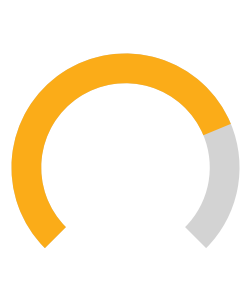

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Exemple de données pour le graphique de jauge
value = 75  # Exemple de pourcentage à remplir
title_text = "Round Category - Side"
gauge_color = "#fbac18"  # Couleur pour le remplissage de la jauge

# Paramètres de la jauge
min_val, max_val = 0, 100
angle_range = -270  # Plage d'angle pour la jauge (3/4 de cercle), avec un pas négatif pour aller de 315° à 44°
value_range = max_val - min_val
fill_angle = angle_range * (value / 100)  # Angle correspondant à la valeur de remplissage

# Création de la figure et de l'axe polaire
fig, ax = plt.subplots(figsize=(3, 3), subplot_kw={'projection': 'polar'})

# Remplissage de la jauge en gris (de 315° à 44°)
ax.barh(1, np.radians(angle_range), left=np.radians(315), color="lightgray", height=0.3)

# Remplissage dynamique en jaune pour la jauge (en fonction de `value`), partant de 315° et avançant dans le sens antihoraire
ax.barh(1, np.radians(fill_angle), left=np.radians(315), color=gauge_color, height=0.3)

# Affichage du pourcentage au centre
ax.text(0, 0, f"{value:.1f}%", ha='center', va='center', fontsize=18, color="white")

# Affichage du titre
plt.title(title_text, color='white', fontsize=14, pad=20)

# Suppression des marques et des étiquettes pour une apparence propre
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xticks([])
ax.spines.clear()

# Fond transparent pour la figure et l'axe
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

# Rotation pour avoir le 0 en bas
ax.set_theta_offset(-np.pi / 2)

# Affichage du graphique
plt.show()
